## Подготовка данных

In [1]:
#так как у меня не была установлена библиотека catboost в колабе, первым делом устанавливаю ее:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
#библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st

#методы
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder)

#модели
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as ltb
from lightgbm import LGBMRegressor

#графики
import matplotlib.pyplot as plt
import seaborn as sns

#дополнительные
RANDOM_STATE=12345

In [3]:
data = pd.read_csv('/content/11.autos.csv')
display(data.head(3))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480.0,2016-04-05 12:47:46


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142387 entries, 0 to 142386
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        142387 non-null  object 
 1   Price              142387 non-null  int64  
 2   VehicleType        127461 non-null  object 
 3   RegistrationYear   142387 non-null  int64  
 4   Gearbox            134457 non-null  object 
 5   Power              142387 non-null  int64  
 6   Model              134487 non-null  object 
 7   Kilometer          142387 non-null  int64  
 8   RegistrationMonth  142387 non-null  int64  
 9   FuelType           129137 non-null  object 
 10  Brand              142387 non-null  object 
 11  Repaired           113727 non-null  object 
 12  DateCreated        142387 non-null  object 
 13  NumberOfPictures   142387 non-null  int64  
 14  PostalCode         142386 non-null  float64
 15  LastSeen           142386 non-null  object 
dtypes:

Ищу пропуски

In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          14926
RegistrationYear         0
Gearbox               7930
Power                    0
Model                 7900
Kilometer                0
RegistrationMonth        0
FuelType             13250
Brand                    0
Repaired             28660
DateCreated              0
NumberOfPictures         0
PostalCode               1
LastSeen                 1
dtype: int64

Пропуски есть в пяти столбцах:
1. тип кузова,
2. тип коробки передач,
3. модель машины,
4. тип топлива,
5. была ли машина в ремонте.
Это важные типы данных и они влияют на стоимость машины. Заполним данные нулями.

In [6]:
data['Model'] = data['Model'].fillna('unknow')
data['FuelType'] = data['FuelType'].fillna('unknow')
data['Repaired'] = data['Repaired'].fillna('unknow')

data['Gearbox'] = data['Gearbox'].fillna(data.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()))
data['VehicleType'] = data['VehicleType'].fillna(data.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))

display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknow,2016-03-24 00:00:00,0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437.0,2016-04-06 10:17:21


Ищу дубликаты

In [7]:
print('Датасет содержит', (data.duplicated().sum()), 'дубликата')

Датасет содержит 0 дубликата


Удаляю их

In [8]:
data = data.drop_duplicates().reset_index(drop=True)
print('Датасет содержит', (data.duplicated().sum()), 'дубликатов')

Датасет содержит 0 дубликатов


Числовые описания данных

In [9]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,142387.000000,142387.000000,142387.000000,142387.000000,142387.000000,142387.0,142386.000000
mean,4424.844522,2004.187285,109.462149,128165.352174,5.711055,0.0,50480.611001
std,4527.113985,87.924125,171.228430,37872.686056,3.726268,0.0,25778.578789
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30163.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49356.000000
75%,6400.000000,2008.000000,141.000000,150000.000000,9.000000,0.0,71106.000000
max,20000.000000,9999.000000,19211.000000,150000.000000,12.000000,0.0,99998.000000


Смущает
1. макс.показатель года выпуска,
2. одинаковые данные в квантилях 50%, 75%, максимальное,
3. мин.мощность = 0.

In [10]:
years_reg = data.pivot_table(index = 'RegistrationYear', values ='Power', aggfunc = 'count').sort_values(by='RegistrationYear', ascending=False)
print(years_reg)

years_reg.plot(grid=True, kind = 'bar', color = 'red', alpha = 0.5, figsize=(100, 100))
plt.title('Выпуск по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество')
plt.show()

                  Power
RegistrationYear       
9999                  9
9450                  1
9000                  1
8888                  1
8500                  1
...                 ...
1234                  3
1200                  1
1111                  1
1001                  1
1000                 16

[121 rows x 1 columns]


Свод и график говорят о вбросах в данных - год регистрации не может быть 1000 или 9999. Оставляю данные за период от 1960-2016 годов.

In [11]:
data = data[(data['RegistrationYear'] >= 1960) & (data['RegistrationYear'] <= 2016)]
display(data.head())

data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknow,2016-03-24 00:00:00,0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437.0,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
Int64Index: 136493 entries, 0 to 142386
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        136493 non-null  object 
 1   Price              136493 non-null  int64  
 2   VehicleType        136493 non-null  object 
 3   RegistrationYear   136493 non-null  int64  
 4   Gearbox            136493 non-null  object 
 5   Power              136493 non-null  int64  
 6   Model              136493 non-null  object 
 7   Kilometer          136493 non-null  int64  
 8   RegistrationMonth  136493 non-null  int64  
 9   FuelType           136493 non-null  object 
 10  Brand              136493 non-null  object 
 11  Repaired           136493 non-null  object 
 12  DateCreated        136493 non-null  object 
 13  NumberOfPictures   136493 non-null  int64  
 14  PostalCode         136492 non-null  float64
 15  LastSeen           136492 non-null  object 
dtypes:

Есть подозрительный пробег

           RegistrationYear
Kilometer                  
150000                91364
125000                14203
100000                 5751
90000                  4381
80000                  4034
70000                  3403
60000                  2946
50000                  2479
40000                  1924
30000                  1761
20000                  1527
10000                   461
5000                   2259


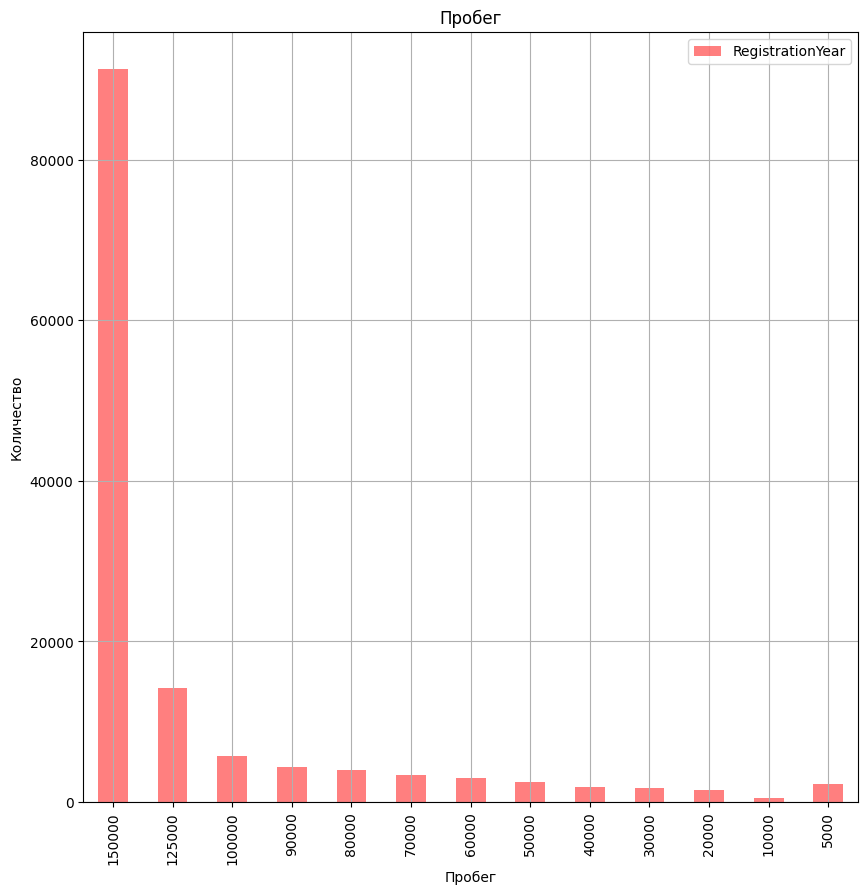

           RegistrationYear  count        price
Kilometer                                      
5000                 2000.0   2259  2774.899070
10000                2013.0    461  9503.843818
20000                2012.0   1527  8647.788474
30000                2012.0   1761  9267.437819
40000                2011.0   1924  9600.832121
50000                2010.0   2479  9134.663977
60000                2009.0   2946  8587.309572
70000                2009.0   3403  8070.905671
80000                2007.0   4034  7263.100892
90000                2007.0   4381  6771.995207
100000               2005.0   5751  5907.120501
125000               2004.0  14203  5136.986411
150000               2001.0  91364  3401.684635


In [12]:
km = data.pivot_table(index = 'Kilometer', values ='RegistrationYear', aggfunc = 'count').sort_values(by='Kilometer', ascending=False)
print(km)

km.plot(grid=True, kind = 'bar', color = 'red', alpha = 0.5, figsize=(10, 10))
plt.title('Пробег')
plt.xlabel('Пробег')
plt.ylabel('Количество')
plt.show()

km_years = data.groupby('Kilometer').agg(RegistrationYear = ('RegistrationYear', 'median'), count = ('RegistrationYear', 'count'), price = ("Price", 'mean'))
print(km_years)

Оставлю данные в исходном виде: основная часть машин 2002 года. За десятилетие похоже на реальный пробег. И стоимость очень доступная.

Удаляю выбросы мощности

In [13]:
data = data[(data['Power'] > 0) & (data['Power'] < 1000)]
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437.0,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775.0,2016-04-06 19:17:07


<class 'pandas.core.frame.DataFrame'>
Int64Index: 121769 entries, 1 to 142386
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        121769 non-null  object 
 1   Price              121769 non-null  int64  
 2   VehicleType        121769 non-null  object 
 3   RegistrationYear   121769 non-null  int64  
 4   Gearbox            121769 non-null  object 
 5   Power              121769 non-null  int64  
 6   Model              121769 non-null  object 
 7   Kilometer          121769 non-null  int64  
 8   RegistrationMonth  121769 non-null  int64  
 9   FuelType           121769 non-null  object 
 10  Brand              121769 non-null  object 
 11  Repaired           121769 non-null  object 
 12  DateCreated        121769 non-null  object 
 13  NumberOfPictures   121769 non-null  int64  
 14  PostalCode         121768 non-null  float64
 15  LastSeen           121768 non-null  object 
dtypes:

In [14]:
data = data[(data['Price'] != 0)]
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437.0,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775.0,2016-04-06 19:17:07


<class 'pandas.core.frame.DataFrame'>
Int64Index: 119191 entries, 1 to 142386
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        119191 non-null  object 
 1   Price              119191 non-null  int64  
 2   VehicleType        119191 non-null  object 
 3   RegistrationYear   119191 non-null  int64  
 4   Gearbox            119191 non-null  object 
 5   Power              119191 non-null  int64  
 6   Model              119191 non-null  object 
 7   Kilometer          119191 non-null  int64  
 8   RegistrationMonth  119191 non-null  int64  
 9   FuelType           119191 non-null  object 
 10  Brand              119191 non-null  object 
 11  Repaired           119191 non-null  object 
 12  DateCreated        119191 non-null  object 
 13  NumberOfPictures   119191 non-null  int64  
 14  PostalCode         119190 non-null  float64
 15  LastSeen           119190 non-null  object 
dtypes:

Смотрю корреляцию показателей. Но сначала удаляю из датасета ненужные данные.
1. RegistrationMonth — месяц регистрации автомобиля,
2. NumberOfPictures — количество фотографий автомобиля,
3. PostalCode — почтовый индекс владельца анкеты (пользователя).

In [15]:
data_corr=data.drop(['NumberOfPictures', 'RegistrationMonth', 'PostalCode'], axis=1)
data_corr.corr(method ='spearman')

<ipython-input-15-7ad868730228>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr.corr(method ='spearman')


,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.665483,0.523841,-0.367844
RegistrationYear,0.665483,1.000000,0.189502,-0.384094
Power,0.523841,0.189502,1.000000,0.118940
Kilometer,-0.367844,-0.384094,0.118940,1.000000


Видна зависимость цены от года регистрации машины и ее мощности

**В итоге:**
1. Изучила данные, удалила вборсы по годам регистрации.
2. Заполнила категориальные признаки значением "unknow".
3. Изучила пробег. Дешевых машин он больше.
4. Посмотерла корреляцию.


## Обучение моделей

Определяю какие данные нам помогут составить представление о цене, а остальные удалим.

1. Оставляем:
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет

2. Удаляем:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [16]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
display(data.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknow,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknow
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Делю на выборки датасет:
1. Определяем целевой признак и остальные признаки.
2. Разделяю на тренировочную валидационную и тестовую выборки.

In [17]:
features_original = data.drop('Price', axis=1)
target = data['Price']


train_valid, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train, valid = train_test_split(train_valid, test_size=0.25, random_state=RANDOM_STATE)

features_train = train.drop(['Price'], axis=1)
target_train = train['Price']

features_valid = valid.drop(['Price'], axis=1)
target_valid = valid['Price']

features_test = test.drop(['Price'], axis=1)
target_test = test['Price']


for i in [features_train, features_valid, features_test]:
    print(i.shape)

print()

(71514, 9)
(23838, 9)
(23839, 9)



3. Определяю категориальные и числовые признаки.
4. Кодирую данные с помощью категориальные данные с помощью ОНЕ

In [18]:
categorial = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer']

features_ohe = pd.get_dummies(features_original, drop_first=True)

features_train_valid_ohe, features_test_ohe, target_train_valid_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size=0.2,
                                                                                            random_state=RANDOM_STATE)

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_train_valid_ohe,
                                                                                            target_train_valid_ohe,
                                                                                            test_size=0.25,
                                                                                            random_state=RANDOM_STATE)

train, valid = train_test_split(train_valid, test_size=0.25, random_state=RANDOM_STATE)


for i in [features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe, features_test_ohe, target_test_ohe]:
    print(i.shape)

print()

display(features_train_ohe.head(3))

(71514, 308)
(23838, 308)
(71514,)
(23838,)
(23839, 308)
(23839,)



,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknow,Repaired_yes
78034,1999,170,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
65256,1999,101,125000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19204,1999,90,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


5. Кодирую категориальные данные с помощью ОЕ.

In [19]:
encoder = OrdinalEncoder()

features_train_oe = categorial
features_train_oe = pd.DataFrame(encoder.fit_transform(features_train),
                                 columns=features_train.columns,
                                 index=features_train.index)

features_valid_oe = categorial
features_valid_oe = pd.DataFrame(encoder.fit_transform(features_valid),
                                columns=features_valid.columns,
                                index=features_valid.index)

features_test_oe = categorial
features_test_oe = pd.DataFrame(encoder.fit_transform(features_test),
                                columns=features_test.columns,
                                index=features_test.index)

target_train_oe = target_train.copy()
target_valid_oe = target_valid.copy()
target_test_oe = target_test.copy()

for i in [features_train_oe, features_valid_oe, target_train_oe, target_valid_oe, features_test_oe, target_test_oe]:
    print(i.shape)

print()

display(features_train_oe.head(3))

(71514, 9)
(23838, 9)
(71514,)
(23838,)
(23839, 9)
(23839,)



,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
78034,4.0,39.0,0.0,163.0,165.0,12.0,6.0,39.0,0.0
65256,4.0,39.0,1.0,95.0,217.0,11.0,6.0,30.0,0.0
19204,5.0,39.0,1.0,84.0,83.0,12.0,6.0,24.0,1.0


Обучаю CatBoostClassifier на двух выборках - ОНЕ и ОЕ

In [20]:
%%time

model1 = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=100)
model1.fit(features_train_ohe, target_train_ohe)


Learning rate set to 0.080385
0:	learn: 4376.9786902	total: 99.3ms	remaining: 1m 39s
100:	learn: 1820.2556828	total: 2.75s	remaining: 24.5s
200:	learn: 1717.3109444	total: 5.5s	remaining: 21.9s
300:	learn: 1660.7458319	total: 8.48s	remaining: 19.7s
400:	learn: 1624.6061508	total: 12.8s	remaining: 19.2s
500:	learn: 1595.9660240	total: 15.2s	remaining: 15.1s
600:	learn: 1570.2988518	total: 17.9s	remaining: 11.9s
700:	learn: 1549.4359203	total: 20.1s	remaining: 8.59s
800:	learn: 1530.9435239	total: 21.4s	remaining: 5.32s
900:	learn: 1514.8950772	total: 22.4s	remaining: 2.46s
999:	learn: 1500.3372009	total: 24.7s	remaining: 0us
CPU times: user 21.4 s, sys: 1.78 s, total: 23.2 s
Wall time: 26.3 s


In [21]:
%%time

pred_valid1 = model1.predict(features_valid_ohe)

CPU times: user 162 ms, sys: 11.6 ms, total: 174 ms
Wall time: 186 ms


In [22]:
rsme_cat_ohe = mean_squared_error(target_valid_ohe, pred_valid1) ** .5

print('RMSE:', rsme_cat_ohe)

RMSE: 1658.5424900387131


In [23]:
%%time

model11 = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=100)
model11.fit(features_train_oe, target_train_oe)

Learning rate set to 0.080385
0:	learn: 4378.5677757	total: 31.9ms	remaining: 31.9s
100:	learn: 1820.3958304	total: 1.18s	remaining: 10.5s
200:	learn: 1713.2884752	total: 2.28s	remaining: 9.06s
300:	learn: 1656.9462757	total: 3.36s	remaining: 7.81s
400:	learn: 1617.9486351	total: 4.54s	remaining: 6.79s
500:	learn: 1587.0181638	total: 5.65s	remaining: 5.63s
600:	learn: 1561.1935926	total: 6.7s	remaining: 4.45s
700:	learn: 1539.1405003	total: 7.72s	remaining: 3.29s
800:	learn: 1520.6873212	total: 8.78s	remaining: 2.18s
900:	learn: 1503.4646427	total: 9.8s	remaining: 1.08s
999:	learn: 1487.8691565	total: 12s	remaining: 0us
CPU times: user 20.1 s, sys: 733 ms, total: 20.9 s
Wall time: 12.3 s


In [24]:
%%time

pred_valid11 = model11.predict(features_valid_oe)

CPU times: user 53.7 ms, sys: 729 µs, total: 54.4 ms
Wall time: 47.9 ms


In [25]:
rsme_cat_oe = mean_squared_error(target_valid_oe, pred_valid11) ** .5

print('RMSE:', rsme_cat_oe)

RMSE: 1864.9891979116396


Обучаю LightGBMRegressor на выборках - ОНЕ и ОЕ

In [26]:
%%time

model2 = LGBMRegressor(random_state=RANDOM_STATE)
model2.fit(features_train_ohe, target_train_ohe)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 71514, number of used features: 262
[LightGBM] [Info] Start training from score 4855.649509
CPU times: user 1.27 s, sys: 128 ms, total: 1.4 s
Wall time: 1.46 s


LGBMRegressor(random_state=12345)

In [27]:
%%time

pred_valid2 = model2.predict(features_valid_ohe)

CPU times: user 227 ms, sys: 26.5 ms, total: 253 ms
Wall time: 254 ms


In [28]:
rsme_lgbmr_ohe = mean_squared_error(target_valid_ohe, pred_valid2) ** .5

print('RMSE:', rsme_lgbmr_ohe)

RMSE: 1730.7277398977876


In [29]:
%%time

model22 = LGBMRegressor(random_state=RANDOM_STATE)
model22.fit(features_train_oe, target_train_oe)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 71514, number of used features: 9
[LightGBM] [Info] Start training from score 4855.649509
CPU times: user 650 ms, sys: 7.77 ms, total: 658 ms
Wall time: 666 ms


LGBMRegressor(random_state=12345)

In [30]:
%%time

pred_valid22 = model22.predict(features_valid_oe)

CPU times: user 175 ms, sys: 923 µs, total: 176 ms
Wall time: 176 ms


In [31]:
rsme_lgbmr_oe = mean_squared_error(target_valid_oe, pred_valid22) ** .5

print('RMSE:', rsme_lgbmr_oe)

RMSE: 1898.4755095559212


Обучаю RandomForestRegressor на двух выборках - ОНЕ и ОЕ

In [32]:
%%time

model3 = RandomForestRegressor(random_state=RANDOM_STATE,n_estimators = 91, criterion = "squared_error")
model3.fit(features_train_ohe, target_train_ohe)

CPU times: user 2min 11s, sys: 605 ms, total: 2min 12s
Wall time: 2min 14s


RandomForestRegressor(n_estimators=91, random_state=12345)

In [33]:
%%time

pred_valid3 = model3.predict(features_valid_ohe)

CPU times: user 1.31 s, sys: 45.9 ms, total: 1.36 s
Wall time: 1.37 s


In [34]:
rsme_rf_ohe = mean_squared_error(target_valid_ohe, pred_valid3) ** .5

print('RMSE:', rsme_rf_ohe)

RMSE: 1721.824183030037


In [35]:
%%time

model33 = RandomForestRegressor(random_state=RANDOM_STATE,n_estimators = 91, criterion = "squared_error")
model33.fit(features_train_oe, target_train_oe)

CPU times: user 20.2 s, sys: 431 ms, total: 20.6 s
Wall time: 20.7 s


RandomForestRegressor(n_estimators=91, random_state=12345)

In [36]:
%%time

pred_valid33 = model33.predict(features_valid_oe)

CPU times: user 759 ms, sys: 1.02 ms, total: 760 ms
Wall time: 760 ms


In [37]:
rsme_rf_oe = mean_squared_error(target_valid_oe, pred_valid33) ** .5

print('RMSE:', rsme_rf_oe)

RMSE: 2076.210282227786


**В итоге:**
1. Обучила три модели двумя разными способами.
2. ОНЕ при любой модели дает лучшие результаты.

## Анализ моделей

Собрала все данные в таблицу

In [38]:
frame_all = pd.DataFrame({'Модель': ['CatBoostRegressor_OHE', 'CatBoostRegressor_OHE', 'LGBMRegressor_OHE',
                          'LGBMRegressor_OE', 'RandomForestRegressor_OHE', 'RandomForestRegressor_OE'],
                          'RMSE': [rsme_cat_ohe, rsme_cat_oe, rsme_lgbmr_ohe, rsme_lgbmr_oe, rsme_rf_ohe, rsme_rf_oe],
                          'Время обучения' : ['30.6 s', '24.8 s', '29.6 s', '4.35 s', '5min 12s', '37.3 s' ],
                          'Время предсказания' : ['130 ms', '59.9 ms', '825 ms', '448 ms', '3.41 s', '2.05 s']})


print(frame_all)

                      Модель         RMSE Время обучения Время предсказания
0      CatBoostRegressor_OHE  1658.542490         30.6 s             130 ms
1      CatBoostRegressor_OHE  1864.989198         24.8 s            59.9 ms
2          LGBMRegressor_OHE  1730.727740         29.6 s             825 ms
3           LGBMRegressor_OE  1898.475510         4.35 s             448 ms
4  RandomForestRegressor_OHE  1721.824183       5min 12s             3.41 s
5   RandomForestRegressor_OE  2076.210282         37.3 s             2.05 s


**В итоге:**
1. Были обучены 3 модели - CatBoostRegressor, LGBMRegressor, RandomForestRegressor.
2. Для кодирования данных были применены методы ОНЕ(создание признаков 0/1) и ОЕ(переводим категорию в число).
3. При обучении все модели показали хороший результат - меньше установленных 2500.
4. Самой лучшей моделью считаю CatBoostRegressor с примененным методом кодировки OHE. у нее минимальная RMSE и ниже среднего время обучения и предсказания.

## Тестирование лучшей модели

Тестирую CatBoostRegressor с примененным методом кодировки OHE

In [39]:
%%time

model_test = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=100)
model_test.fit(features_train_ohe, target_train_ohe)

Learning rate set to 0.080385
0:	learn: 4376.9786902	total: 11.8ms	remaining: 11.8s
100:	learn: 1820.2556828	total: 1.09s	remaining: 9.68s
200:	learn: 1717.3109444	total: 2.09s	remaining: 8.32s
300:	learn: 1660.7458319	total: 3.08s	remaining: 7.15s
400:	learn: 1624.6061508	total: 4.24s	remaining: 6.33s
500:	learn: 1595.9660240	total: 6.66s	remaining: 6.64s
600:	learn: 1570.2988518	total: 7.64s	remaining: 5.07s
700:	learn: 1549.4359203	total: 8.64s	remaining: 3.68s
800:	learn: 1530.9435239	total: 9.62s	remaining: 2.39s
900:	learn: 1514.8950772	total: 11.4s	remaining: 1.25s
999:	learn: 1500.3372009	total: 13.1s	remaining: 0us
CPU times: user 20.2 s, sys: 839 ms, total: 21.1 s
Wall time: 13.9 s


In [40]:
%%time

pred_test = model_test.predict(features_test_ohe)

CPU times: user 153 ms, sys: 6.97 ms, total: 160 ms
Wall time: 93.5 ms


In [41]:
rsme_cat_ohe = mean_squared_error(target_test_ohe, pred_test) ** .5

print('RMSE на тестовой выборке:', rsme_cat_ohe)

RMSE на тестовой выборке: 1636.6446211085731


RMSE меньше 2500 и значит ее можно презентовать заказчику.

## Выводы:

1. Подобраны модели бустинга для обучения CatBoostRegressor, LGBMRegressor и выбарана простая модель RandomForestRegressor.
2. Для обучения категориальные данные закодировала методами ОНЕ и ОЕ.
3. По итогам обучения все модели показали хороший результат. Лучше всего справилась модель CatBoostRegressor с примененным методом кодировки OHE. Ее взяла для тестирования.
4. При тестировании модели получили: RMSE = 1589 при пороге 2500, скорость обучения = 25 секунд, скорость предсказаний = 110 милисекундам.
5. Модель подходит заказчику по всем критериям.